### Импорт библиотек и загрузка файлов

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import BertConfig, TFBertModel
from tensorflow.keras.layers import Input, Conv2D, Reshape, Flatten, Dense, Dropout, Bidirectional, GRU, Lambda, Conv1D, RepeatVector
from tensorflow.keras.optimizers import Adam

from modules.data_transformation import *
from modules.model_evaluation import (evaluate_regression_model, evaluate_classification_model, plot_learning_curves)

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# MMgRNA dataset

In [44]:
df = pd.read_csv(r"data/Table_S8_machine_learning_input.csv", engine="python", sep='\t')

In [46]:
df.rename(columns={
    "perfect match sgRNA": "perfect_match_sgRNA",
    "sgRNA sequence": "sgRNA_sequence",
    "mismatch position": "mismatch_position",
    "new pairing": "new_pairing",
    "mean relative gamma": "mean_relative_gamma",
    "genome input": "genome_input",
    "sgRNA input": "sgRNA_input"
}, inplace=True)

In [41]:
bert_df = pd.read_csv("data/bert_embeddings.csv", index_col=0)

bert_embeddings = bert_df.to_numpy()

df = df.reset_index()
df = df.merge(bert_df, left_index=True, right_index=True)

print(f"✅ Данные объединены! df.shape: {df.shape}")

✅ Данные объединены! df.shape: (26248, 530)


In [7]:
# df['encoded_or'] = df.apply(
#     lambda row: encode_or(
#         row['genome_input'],
#         row['sgRNA_input']
#     ).flatten(),
#     axis=1
# )

df['encoded_7channels'] = df.apply(
    lambda row: encode_7channels_mmrna_26(
        row['genome_input'],
        row['sgRNA_input']
    ).flatten(),
    axis=1
)

df['mismatch_count'] = df.apply(
    lambda row: count_mismatches(row['genome_input'], row['sgRNA_input']),
    axis=1
)

df['gc_genome'] = df['genome_input'].apply(calc_gc_content)
df['gc_sgrna'] = df['sgRNA_input'].apply(calc_gc_content)

df['pam'] = df['sgRNA_input'].apply(pam_mmrna_26)

In [48]:
df['genome_input_rna'] = df['genome_input'].apply(dna_to_rna)
df['sgRNA_input_rna'] = df['sgRNA_input'].apply(dna_to_rna)

# Generating CRISPR-BERT Embeddings

In [8]:
# Словарь кодировки пар оснований
base_pair_dict = {
    "AA": 2, "AC": 3, "AG": 4, "AT": 5,
    "CA": 6, "CC": 7, "CG": 8, "CT": 9,
    "GA": 10, "GC": 11, "GG": 12, "GT": 13,
    "TA": 14, "TC": 15, "TG": 16, "TT": 17,
    "A_": 18, "_A": 19, "C_": 20, "_C": 21,
    "G_": 22, "_G": 23, "T_": 24, "_T": 25
}

def BERT_encode(sequence_pairs, max_length=26):
    """
    Кодирует список sgRNA-ДНК пар в числовые последовательности для подачи в BERT.
    
    :param sequence_pairs: список кортежей (sgRNA, DNA)
    :param max_length: максимальная длина последовательности (например, 26)
    :return: numpy массивы с токенами и позиционной информацией
    """
    encoded_sequences = []
    
    for sgRNA, DNA in sequence_pairs:
        assert len(sgRNA) == len(DNA), "Длины sgRNA и DNA должны совпадать"
        
        tokens = [0]  # [CLS] в начале
        for r, d in zip(sgRNA, DNA):
            pair = r + d
            tokens.append(base_pair_dict.get(pair, 1))  # 1 - если неизвестная пара
        tokens.append(1)  # [SEP] в конце

        # Дополнение до max_length
        while len(tokens) < max_length:
            tokens.append(0)  # [PAD]
        
        encoded_sequences.append(tokens[:max_length])  # Обрезка, если больше max_length

    return np.array(encoded_sequences, dtype=np.int32)

In [9]:
checkpoint_path = r"./weight/bert_weight/uncased_L-2_H-256_A-4/bert_model.ckpt"
checkpoint = tf.train.Checkpoint()
checkpoint.restore(checkpoint_path).expect_partial()

print("Модель успешно загружена!")

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.
Модель успешно загружена!


In [10]:
config_path = r"./weight/bert_weight/uncased_L-2_H-256_A-4/bert_config.json"
config = BertConfig.from_json_file(config_path)

print("✅ Конфигурация загружена!")

✅ Конфигурация загружена!


In [11]:
bert_model = TFBertModel(config)
print("✅ BERT-модель создана!")


✅ BERT-модель создана!


In [12]:
checkpoint_path = r"./weight/bert_weight/uncased_L-2_H-256_A-4/bert_model.ckpt"
bert_model.load_weights(checkpoint_path)

print("✅ Веса загружены в BERT!")


✅ Веса загружены в BERT!


In [13]:
# Создание списка пар sgRNA-ДНК
sequence_pairs = list(zip(df["sgRNA_input"], df["genome_input"]))

# Кодируем последовательности
bert_inputs = BERT_encode(sequence_pairs, max_length=26)

# Преобразуем в нужный формат
bert_inputs = np.array(bert_inputs)

# Генерация маски (1 для токенов, 0 для паддингов)
attention_mask = np.where(bert_inputs != 0, 1, 0)

# Передача в BERT
bert_outputs = bert_model.predict([bert_inputs, attention_mask])

# Усредняем эмбеддинги по токенам
bert_embeddings = np.mean(bert_outputs.last_hidden_state, axis=1)

print("✅ BERT эмбеддинги получены!", bert_embeddings.shape)

821/821 [==============================] - 23s 20ms/step
✅ BERT эмбеддинги получены! (26248, 256)


In [ ]:
bert_df = pd.DataFrame(bert_embeddings)
bert_df.to_csv("data/bert_embeddings.csv", index=True)

# Models

## MLP

In [53]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, df["mean_relative_gamma"].values, test_size=0.2, random_state=42)

print(f"✅ Данные готовы! X_train: {X_train.shape}, y_train: {y_train.shape}")

✅ Данные готовы! X_train: (20998, 256), y_train: (20998,)


In [54]:
# Создаем модель
model = Sequential([
    Dense(128, activation="relu", input_shape=(256,)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="linear")  # Регрессия
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Вывод структуры
model.summary()

d:\polina\CRISPR\crispr\crispr-bert\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,265 (169.00 KB)

 Trainable params: 43,265 (169.00 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=32,
    verbose=1
)

Epoch 1/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1667 - mae: 0.3338 - val_loss: 0.1546 - val_mae: 0.3111
Epoch 2/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1503 - mae: 0.3249 - val_loss: 0.1500 - val_mae: 0.3291
Epoch 3/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1482 - mae: 0.3245 - val_loss: 0.1493 - val_mae: 0.3339
Epoch 4/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1477 - mae: 0.3246 - val_loss: 0.1491 - val_mae: 0.3270
Epoch 5/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1488 - mae: 0.3268 - val_loss: 0.1519 - val_mae: 0.3240
Epoch 6/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1487 - mae: 0.3256 - val_loss: 0.1510 - val_mae: 0.3431
Epoch 7/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1488 - mae: 0.3253 - val_loss: 0.1479 - val_mae: 0.3212
Epoch 8/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1493 - mae: 0.3262 - val_loss: 0.1503 - val_mae: 0.3180
Epoch 9/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

In [57]:
results_df, mse, mae, r2 = evaluate_regression_model(model, X_test, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1470 - mae: 0.3215
Test Loss (MSE): 0.14490
Test MAE: 0.31908
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.14490
Mean Absolute Error (MAE): 0.31908
R² Score: 0.05011


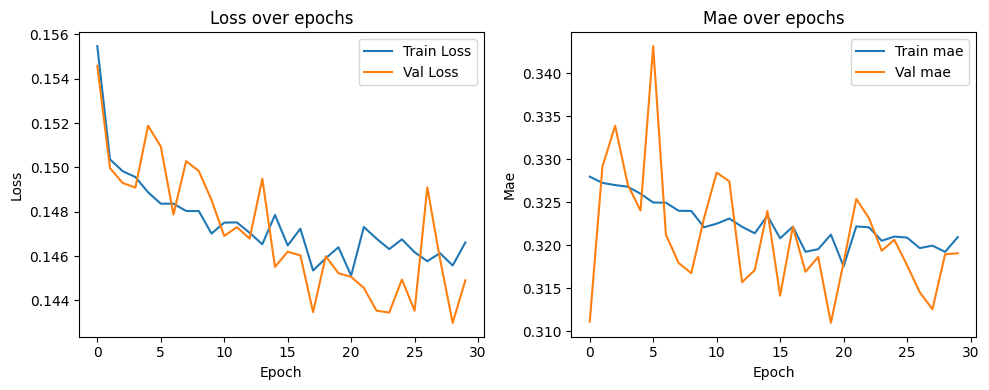

In [ ]:
plot_learning_curves(history, metric='mae')

## CNN

In [ ]:
# Преобразуем эмбеддинги BERT для подачи в Conv1D
X_reshaped = np.expand_dims(bert_embeddings, axis=-1)  # (samples, 256, 1)

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, df["mean_relative_gamma"].values, test_size=0.2, random_state=42)

print(f"✅ Данные готовы! X_train: {X_train.shape}, y_train: {y_train.shape}")

✅ Данные готовы! X_train: (20998, 256, 1), y_train: (20998,)


In [ ]:
# Входной слой
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Сверточный слой
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Flatten()(x)  # Преобразуем в одномерный вектор
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Выходной слой (регрессия)
output_layer = Dense(1, activation='linear')(x)

# Определяем модель
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE + MAE

# Вывод структуры модели
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 256, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,593 (2.01 MB)

 Trainable params: 526,593 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=32,
    verbose=1
)

Epoch 1/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1740 - mae: 0.3304 - val_loss: 0.1526 - val_mae: 0.3308
Epoch 2/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.1526 - mae: 0.3307 - val_loss: 0.1526 - val_mae: 0.3326
Epoch 3/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.1519 - mae: 0.3304 - val_loss: 0.1530 - val_mae: 0.3389
Epoch 4/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1508 - mae: 0.3302 - val_loss: 0.1527 - val_mae: 0.3279
Epoch 5/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1510 - mae: 0.3285 - val_loss: 0.1525 - val_mae: 0.3324
Epoch 6/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1523 - mae: 0.3326 - val_loss: 0.1526 - val_mae: 0.3327
Epoch 7/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1511 - mae: 0.3298 - val_loss: 0.1526 - val_mae: 0.3310
Epoch 8/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1506 - mae: 0.3285 - val_loss: 0.1529 - val_mae: 0.3383
Epoch 9/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1550 - mae: 0.3348
Test Loss (MSE): 0.15255
Test MAE: 0.33193
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.15255
Mean Absolute Error (MAE): 0.33193
R² Score: -0.00000


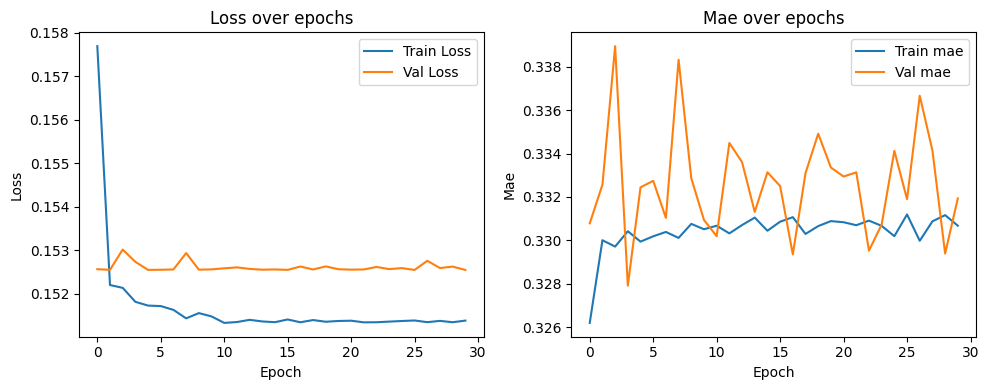

In [63]:
results_df, mse, mae, r2 = evaluate_regression_model(model, X_test, y_test)
plot_learning_curves(history, metric='mae')

## CRISPR-BERT architecture

In [16]:
# BERT-эмбеддинги (размер: samples, 256)
X_bert = bert_embeddings

# 7-канальная кодировка (размер: samples, 26, 7)
# ✅ Преобразуем список массивов в корректный numpy-массив (26, 7)
X_encoded = np.array([x.reshape(26, 7) for x in df["encoded_7channels"].values])

# Целевая переменная
y = df["mean_relative_gamma"].values

# Разделение на train/test
X_bert_train, X_bert_test, X_enc_train, X_enc_test, y_train, y_test = train_test_split(
    X_bert, X_encoded, y, test_size=0.2, random_state=42
)

print(f"✅ Данные готовы! X_bert_train: {X_bert_train.shape}, X_enc_train: {X_enc_train.shape}, y_train: {y_train.shape}")

✅ Данные готовы! X_bert_train: (20998, 256), X_enc_train: (20998, 26, 7), y_train: (20998,)


In [20]:
def build_crispr_regression():
    # Входы
    X_in = Input(shape=(26, 7))  # 7-канальная кодировка
    X_bert_in = Input(shape=(256,))  # BERT-эмбеддинги

    # CNN + BiGRU обработка 7-канальной кодировки
    x = Reshape((26, 7, 1))(X_in)
    conv_1 = Conv2D(5, (1, 1), padding="same", activation="relu")(x)
    conv_2 = Conv2D(15, (2, 2), padding="same", activation="relu")(x)
    conv_3 = Conv2D(25, (3, 3), padding="same", activation="relu")(x)
    conv_4 = Conv2D(35, (5, 5), padding="same", activation="relu")(x)
    conv_output = tf.keras.layers.concatenate([conv_1, conv_2, conv_3, conv_4])  # (26, 7, 80)

    # Корректное приведение формы
    conv_output = Flatten()(conv_output)  # (26 * 7 * 80,) = (14560,)
    conv_output = Dense(2080, activation="relu")(conv_output)  # Сжимаем
    conv_output = Reshape((26, 80))(conv_output)  # Теперь размер правильный
    conv_output = Bidirectional(GRU(40, return_sequences=True))(conv_output)

    # Обработка BERT-эмбеддингов
    x_bert = Dense(128, activation="relu")(X_bert_in)
    x_bert = Dropout(0.3)(x_bert)
    x_bert = Dense(64, activation="relu")(x_bert)
    x_bert = Dropout(0.3)(x_bert)

    # ✅ Вставляем исправление здесь
    x_bert = RepeatVector(26)(x_bert)  # Теперь (None, 26, 64)

    x_bert = Bidirectional(GRU(40, return_sequences=True))(x_bert)  # (None, 26, 80)

    # Объединение признаков
    feature_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=-1))  # Соединение фич
    weight_1 = Lambda(lambda x: x * 0)  # Вес 0.2 для CNN+BiGRU
    weight_2 = Lambda(lambda x: x * 1)  # Вес 0.8 для BERT
    x = feature_concat([weight_1(conv_output), weight_2(x_bert)])

    # Финальные слои
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.35)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.35)(x)

    # Выходной слой (регрессия)
    output = Dense(1, activation="linear")(x)

    # Определяем модель
    model = Model(inputs=[X_in, X_bert_in], outputs=output)
    model.compile(loss="mse", optimizer=Adam(0.0001), metrics=["mae"])

    print(model.summary())
    return model

### Вес 0.2 для CNN+BiGRU, Вес 0.8 для BERT

In [ ]:
# Очищаем сессию
K.clear_session()

# Создаем заново модель
model = build_crispr_regression()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 26, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 26, 7, 1)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 7, 5)  │         10 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 26, 7, 15) │         75 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 26, 7, 25) │        250 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 26, 7, 35) │        910 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 26, 7, 80) │          0 │ conv2d[0][0],     │
│ (Concatenate)       │                   │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 14560)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2080)      │ 30,286,880 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 26, 80)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 26, 64)    │          0 │ dropout_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 26, 80)    │     29,280 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 26, 80)    │     25,440 │ repeat_vector[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 26, 80)    │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 26, 80)    │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 26, 160)   │          0 │ lambda_1[0][0], 

 Total params: 30,924,926 (117.97 MB)

 Trainable params: 30,924,926 (117.97 MB)

 Non-trainable params: 0 (0.00 B)

None


In [82]:
# Коллбэки (опционально)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

history = model.fit(
    [X_enc_train, X_bert_train],  # Входные данные (7-канальная кодировка + BERT)
    y_train,                      # Целевая переменная
    batch_size=32,                 
    epochs=10,                    
    validation_data=([X_enc_test, X_bert_test], y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 196s 298ms/step - loss: 0.1150 - mae: 0.2522 - val_loss: 0.0922 - val_mae: 0.2016 - learning_rate: 1.0000e-04
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 200s 304ms/step - loss: 0.0881 - mae: 0.2106 - val_loss: 0.0790 - val_mae: 0.1932 - learning_rate: 1.0000e-04
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 186s 283ms/step - loss: 0.0801 - mae: 0.2011 - val_loss: 0.0762 - val_mae: 0.1905 - learning_rate: 1.0000e-04
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 217s 330ms/step - loss: 0.0711 - mae: 0.1895 - val_loss: 0.0715 - val_mae: 0.1805 - learning_rate: 1.0000e-04
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 277s 353ms/step - loss: 0.0605 - mae: 0.1713 - val_loss: 0.0613 - val_mae: 0.1739 - learning_rate: 1.0000e-04
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 232s 353ms/step - loss: 0.0508 - mae: 0.1534 - val_loss: 0.0573 - val_mae: 0.1631 - learning_rate: 1.0000e-04
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 226s 345ms/step - loss: 0.0412 - mae: 0.1383 - val_loss: 0.0

In [86]:
model.save("crispr_regression_model.keras")

165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0510 - mae: 0.1518
Test Loss (MSE): 0.05263
Test MAE: 0.15399
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05263
Mean Absolute Error (MAE): 0.15399
R² Score: 0.65500


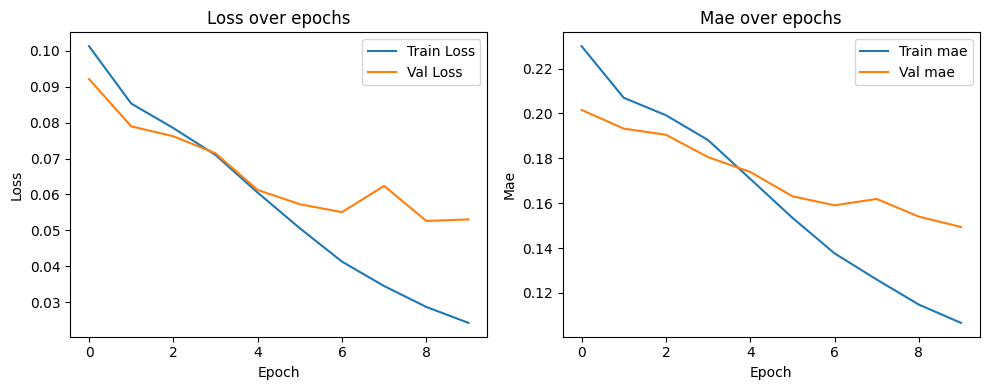

In [85]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_enc_test, X_bert_test], y_test)
plot_learning_curves(history, metric='mae')

### Вес 0 для CNN+BiGRU, Вес 1 для BERT

In [25]:
def build_bert_regression():
    # Входной слой для BERT-эмбеддингов
    X_bert_in = Input(shape=(256,))

    # Полносвязные слои
    x = Dense(128, activation="relu")(X_bert_in)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)

    # Выходной слой (регрессия)
    output = Dense(1, activation="linear")(x)

    # Определяем модель
    model = Model(inputs=X_bert_in, outputs=output)
    model.compile(loss="mse", optimizer=Adam(0.0001), metrics=["mae"])

    print(model.summary())
    return model

# Создаем и проверяем модель
model = build_bert_regression()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,217 (161.00 KB)

 Trainable params: 41,217 (161.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
# Очищаем сессию
K.clear_session()

# Создаем заново модель
model = build_bert_regression()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,217 (161.00 KB)

 Trainable params: 41,217 (161.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Коллбэки (опционально)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_bert_train, y_train,  # Только BERT-эмбеддинги
    batch_size=32,
    epochs=20,
    validation_data=(X_bert_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2677 - mae: 0.4024 - val_loss: 0.1536 - val_mae: 0.3027 - learning_rate: 1.0000e-04
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1535 - mae: 0.3220 - val_loss: 0.1522 - val_mae: 0.3026 - learning_rate: 1.0000e-04
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1542 - mae: 0.3227 - val_loss: 0.1473 - val_mae: 0.3125 - learning_rate: 1.0000e-04
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1510 - mae: 0.3208 - val_loss: 0.1453 - val_mae: 0.3155 - learning_rate: 1.0000e-04
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1480 - mae: 0.3165 - val_loss: 0.1468 - val_mae: 0.3082 - learning_rate: 1.0000e-04
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1476 - mae: 0.3157 - val_loss: 0.1464 - val_mae: 0.3076 - learning_rate: 1.0000e-04
Epoch 7/20
640/657 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1492 - mae: 0.3184
Epoch 7: ReduceLROnPlateau reducing learnin

In [ ]:
#model.save("crispr_regression_model_1.keras")

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1425 - mae: 0.3171
Test Loss (MSE): 0.14086
Test MAE: 0.31572
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Regression Metrics:
Mean Squared Error (MSE): 0.14086
Mean Absolute Error (MAE): 0.31572
R² Score: 0.07663


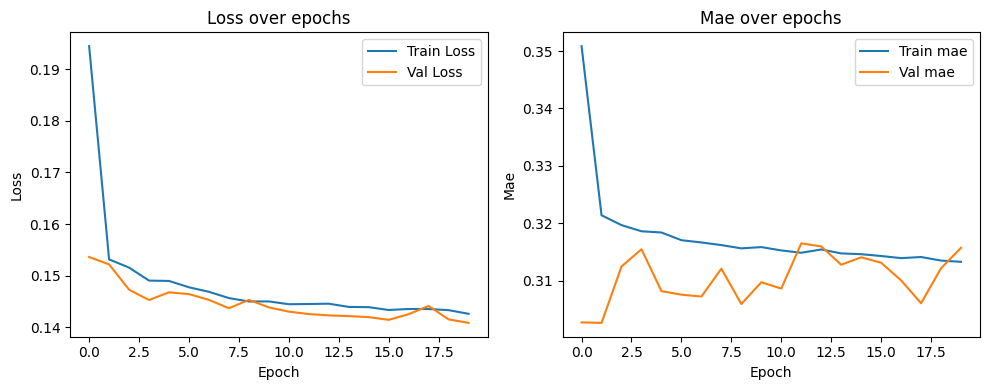

In [29]:
results_df, mse, mae, r2 = evaluate_regression_model(model, X_bert_test, y_test)
plot_learning_curves(history, metric='mae')

In [30]:
# Коллбэки (опционально)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_bert_train, y_train,  # Только BERT-эмбеддинги
    batch_size=32,
    epochs=50,
    validation_data=(X_bert_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1394 - mae: 0.3092 - val_loss: 0.1417 - val_mae: 0.3094 - learning_rate: 2.5000e-05
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1407 - mae: 0.3114 - val_loss: 0.1406 - val_mae: 0.3130 - learning_rate: 2.5000e-05
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1410 - mae: 0.3114 - val_loss: 0.1417 - val_mae: 0.3062 - learning_rate: 2.5000e-05
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1427 - mae: 0.3118 - val_loss: 0.1416 - val_mae: 0.3070 - learning_rate: 2.5000e-05
Epoch 5/50
643/657 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1417 - mae: 0.3120
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1417 - mae: 0.3120 - val_loss: 0.1408 - val_mae: 0.3123 - learning_rate: 2.5000e-05
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1415 - mae: 0.3125 - val_loss: 0.1406 - val_mae: 0.3098 - lear

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1419 - mae: 0.3132
Test Loss (MSE): 0.14019
Test MAE: 0.31164
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Regression Metrics:
Mean Squared Error (MSE): 0.14019
Mean Absolute Error (MAE): 0.31164
R² Score: 0.08100


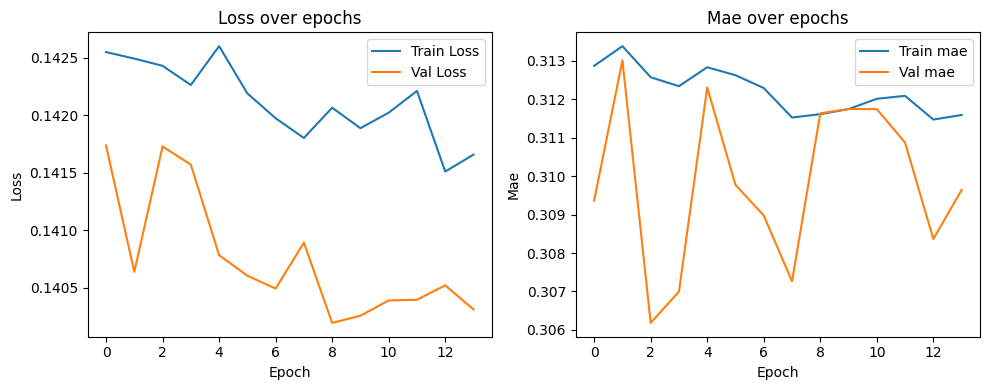

In [31]:
results_df, mse, mae, r2 = evaluate_regression_model(model, X_bert_test, y_test)
plot_learning_curves(history, metric='mae')

### Вес 1 для CNN+BiGRU, Вес 0 для BERT

In [32]:
def build_cnn_bigru_regression():
    # Входной слой (7-канальная кодировка)
    X_in = Input(shape=(26, 7))

    # CNN + BiGRU обработка
    x = Reshape((26, 7, 1))(X_in)
    conv_1 = Conv2D(5, (1, 1), padding="same", activation="relu")(x)
    conv_2 = Conv2D(15, (2, 2), padding="same", activation="relu")(x)
    conv_3 = Conv2D(25, (3, 3), padding="same", activation="relu")(x)
    conv_4 = Conv2D(35, (5, 5), padding="same", activation="relu")(x)
    conv_output = tf.keras.layers.concatenate([conv_1, conv_2, conv_3, conv_4])  # (26, 7, 80)

    # Корректное приведение формы
    conv_output = Flatten()(conv_output)  # (26 * 7 * 80,) = (14560,)
    conv_output = Dense(2080, activation="relu")(conv_output)  # Сжимаем
    conv_output = Reshape((26, 80))(conv_output)  # Теперь размер правильный
    conv_output = Bidirectional(GRU(40, return_sequences=False))(conv_output)  # Теперь (None, 80)

    # Финальные слои
    x = Dense(128, activation="relu")(conv_output)
    x = Dropout(0.35)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.35)(x)

    # Выходной слой (регрессия)
    output = Dense(1, activation="linear")(x)

    # Определяем модель
    model = Model(inputs=X_in, outputs=output)
    model.compile(loss="mse", optimizer=Adam(0.0001), metrics=["mae"])

    print(model.summary())
    return model

# Создаем модель
model = build_cnn_bigru_regression()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 26, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 26, 7, 1)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 7, 5)  │         10 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 26, 7, 15) │         75 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 26, 7, 25) │        250 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 26, 7, 35) │        910 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 26, 7, 80) │          0 │ conv2d[0][0],     │
│ (Concatenate)       │                   │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 14560)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2080)      │ 30,286,880 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 26, 80)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 80)        │     29,280 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     10,368 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,336,094 (115.72 MB)

 Trainable params: 30,336,094 (115.72 MB)

 Non-trainable params: 0 (0.00 B)

None


In [33]:
history = model.fit(
    X_enc_train, y_train,  # Только 7-канальная кодировка
    batch_size=32,
    epochs=10,
    validation_data=(X_enc_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 158s 232ms/step - loss: 0.1149 - mae: 0.2550 - val_loss: 0.0788 - val_mae: 0.2031 - learning_rate: 1.0000e-04
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 166s 253ms/step - loss: 0.0840 - mae: 0.2083 - val_loss: 0.0750 - val_mae: 0.1912 - learning_rate: 1.0000e-04
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 195s 241ms/step - loss: 0.0776 - mae: 0.1990 - val_loss: 0.0698 - val_mae: 0.1814 - learning_rate: 1.0000e-04
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 162s 247ms/step - loss: 0.0665 - mae: 0.1821 - val_loss: 0.0697 - val_mae: 0.1780 - learning_rate: 1.0000e-04
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 154s 234ms/step - loss: 0.0583 - mae: 0.1692 - val_loss: 0.0598 - val_mae: 0.1644 - learning_rate: 1.0000e-04
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 149s 226ms/step - loss: 0.0478 - mae: 0.1506 - val_loss: 0.0562 - val_mae: 0.1632 - learning_rate: 1.0000e-04
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 148s 226ms/step - loss: 0.0400 - mae: 0.1366 - val_loss: 0.0

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0485 - mae: 0.1447
Test Loss (MSE): 0.05108
Test MAE: 0.14888
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05108
Mean Absolute Error (MAE): 0.14888
R² Score: 0.66513


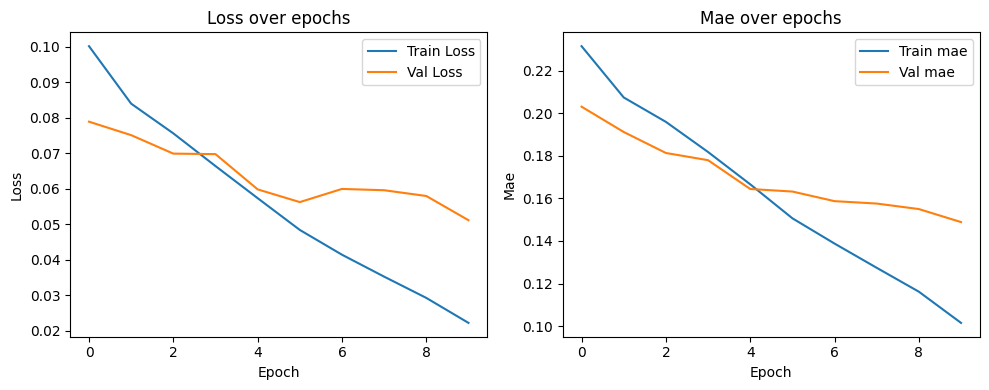

In [36]:
results_df, mse, mae, r2 = evaluate_regression_model(model, X_enc_test, y_test)
plot_learning_curves(history, metric='mae')